<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###All important libraries/modules that may be needed:
1. torchvision
2. torchvision.datasets: has a range of toy datasets for different purposes
3. torchvision.models:
4. torchvision.transforms
5. torch.utils.data.Dataset
6. torch.utils.data.Dataloader

In [2]:
#getting libraries
import torch
from torch import nn

#import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#import matplotlib
import matplotlib.pyplot as plt

#chacking versions
print("PyTorch version:", torch.__version__, "Torchvision version:", torchvision.__version__)

PyTorch version: 2.1.0+cu121 Torchvision version: 0.16.0+cu121


####Getting Training and Testing Data from Torchvision.datasets

In [3]:
train_data=datasets.GTSRB(root="Traffic_Signal_Data",#telling where to store the data
                          split="train",#specifying if its training data or testing data
                          download=True,#to download or not in case data not already present
                          transform=ToTensor(),#which function to use to tranform PIL image into tensor
                          target_transform=None#can transform labels using this#not necessary to use here as we are just assigning None value to it(labels dont need transformation)
                          )
test_data=datasets.GTSRB(root="Traffic_Signal_Data",#telling where to store the data
                          split="test",#specifying if its training data or testing data
                          download=True,#to download or not in case data not already present
                          transform=ToTensor(),#which function to use to tranform PIL image into tensor
                          target_transform=None#can transform labels using this
                          )

100%|██████████| 187490228/187490228 [00:01<00:00, 113829652.10it/s]


Extracting Traffic_Signal_Data/gtsrb/GTSRB-Training_fixed.zip to Traffic_Signal_Data/gtsrb


100%|██████████| 88978620/88978620 [00:00<00:00, 98069679.76it/s] 


Extracting Traffic_Signal_Data/gtsrb/GTSRB_Final_Test_Images.zip to Traffic_Signal_Data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 1497912.01it/s]

Extracting Traffic_Signal_Data/gtsrb/GTSRB_Final_Test_GT.zip to Traffic_Signal_Data/gtsrb


In [11]:
data, label= train_data[12]
data.shape, label #output tells shape of data and the label which is an integer
#first index of shape gives number of colour channels, if its 3 then image is in RGB

(torch.Size([3, 38, 37]), 0)

Checking Length of Train and Test dataset

In [5]:
train_data.__len__(),test_data.__len__() #find dataset specific methods from source code

(26640, 12630)

Printing the data in dataset labels

In [6]:
labels=[]
for i in range(train_data.__len__()):
  data,label=train_data[i]
  labels.append(label)
set(labels)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42}

Visualizing Data

Image Shape:torch.Size([3, 59, 62])


Text(0.5, 1.0, '5')

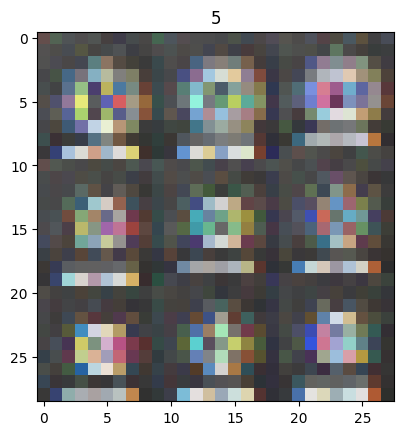

In [7]:
import matplotlib.pyplot as plt
image,label=train_data[5555]
print(f"Image Shape:{data.shape}")
image=image.view(image.shape[1],image.shape[2], image.shape[0])
plt.imshow(image)
plt.title(label)

Making Batches


In [9]:
from torch.utils.data import DataLoader
#for large datasets its computationally faster to work in batches rather than working with individual datasets
#setting batch size hyperparameter
BATCH_SIZE= 32

train_dataloader=DataLoader(train_data,#target dataset
                            batch_size=BATCH_SIZE,#batch size
                            shuffle=True)#whether to shuffle the datapoints or not so that neural network does not get trained on some unobvious pattern present in ordering of data points
test_dataloader=DataLoader(test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)#can make it shuffle but its not necessary and will add another calculation step in every epoch
print(train_dataloader, test_dataloader)
print(len(train_dataloader), len(test_dataloader))

<torch.utils.data.dataloader.DataLoader object at 0x7bf987774520> <torch.utils.data.dataloader.DataLoader object at 0x7bfa4fcfd1e0>
833 395


In [10]:
#checking data inside data loader
train_features_batch, train_labels_batch= next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
#need to use different dataset

RuntimeError: stack expects each tensor to be equal size, but got [3, 142, 131] at entry 0 and [3, 33, 32] at entry 1